In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_ as clip_grad

import os
import pandas as pd
import numpy as np
import random
import glob

from tqdm.auto import tqdm as tq
import warnings
warnings.filterwarnings(action='ignore')


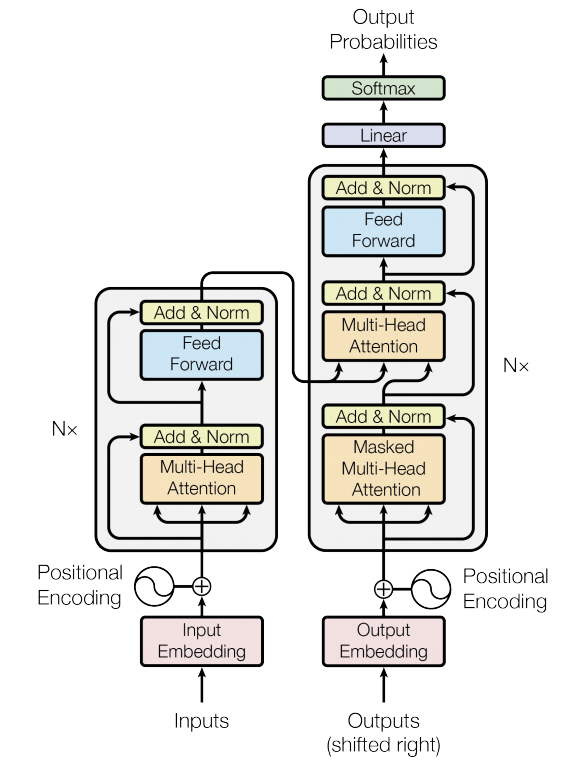

### functions

In [ ]:
def load_batch(X, Y, batch_size, shuffle=True):
    if shuffle:
        permutation = np.random.permutation(X.shape[0])
        X = X[permutation, :]
        Y = Y[permutation, :]
    num_steps = int(X.shape[0])//batch_size
    step = 0
    while step<num_steps:
        X_batch = X[batch_size*step:batch_size*(step+1)]
        Y_batch = Y[batch_size*step:batch_size*(step+1)]
        step+=1
        yield X_batch, Y_batch
        
        
def valid(model, device, optimizer, criterion, batch_size, X_val, Y_val):
    # mode change
    model.eval()
    val_loss = []
    
    # avoid unnecessary calculations
    with torch.no_grad():
        for X_batch, Y_batch in load_batch(X_val, Y_val, batch_size):
            # forward
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            yhat = model(X_batch)
                
            # loss
            loss = criterion(yhat, Y_batch)
            
            # save loss values
            val_loss.append(loss.item())
            
    return np.mean(val_loss)


def train(model, device, criterion, optimizer, scheduler, clip, X_train, Y_train, X_val, Y_val, lr, n_epochs, batch_size, max_norm):
    model.to(device)
    
    best_loss  = 9999
    best_model = None
    
    for epoch in tq(range(1, n_epochs)):
        train_loss = []
        
        # mode change
        model.train()
        for X_batch, Y_batch in load_batch(X_train, Y_train, batch_size):
            optimizer.zero_grad()

            # forward
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)            
            yhat = model(X_batch)
            
            # loss
            loss = criterion(yhat, Y_batch)
            
            # backward
            loss.backward()
            if clip :
                clip_grad(model.parameters(), max_norm)
            optimizer.step()
            
            # save loss values
            train_loss.append(loss.item())
            
        val_loss = valid(model, device, optimizer, criterion, batch_size, X_val, Y_val)
        print(f'Train Loss : [{np.mean(train_loss):.5f}] Valid Loss : [{val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step()
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
    return best_model


def preprocessing1(X_input, Y_input, X_container, Y_container):    
    y_maxlen = 0
    for x,y in tq(zip(X_input, Y_input)):
        curx = pd.read_csv(x).drop(columns = ["시간"]).fillna(0).values
        x_len = len(curx)//1440
        x_temp = []
        for idx in range(x_len):
            x_temp.append(curx[1440*idx : 1440*(idx+1)])
        x_temp = torch.Tensor(x_temp)
        X_container.append(x_temp)
        y_temp = torch.Tensor(pd.read_csv(y)["rate"].fillna(0).values)
        y_temp = y_temp.reshape(y_temp.size()[0], 1)
        Y_container.append(y_temp)
    return;


def preprocessing2(X_input, Y_input, X_container, Y_container):    
    y_maxlen = 0
    for x,y in tq(zip(X_input, Y_input)):
        curx = pd.read_csv(x).drop(columns = ["시간"]).fillna(0)
        x_len = len(curx)//1440
        x_temp = []
        for idx in range(x_len):
            cur_day = curx[1440*idx : 1440*(idx+1)]
            x_day = []
            for hour in range(24//2):
                hour_data = cur_day.iloc[hour*60//2].T
                x_day.append(hour_data)    
            x_day = np.vstack(x_day)
            x_temp.append(x_day)
        
        x_temp = torch.Tensor(x_temp)
        X_container.append(x_temp)
        y_temp = torch.Tensor(pd.read_csv(y)["rate"].fillna(0).values)
        y_temp = y_temp.reshape(y_temp.size()[0], 1)
        Y_container.append(y_temp)
    return;


'''Loss function'''
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, ygt):
        return torch.sqrt(self.mse(yhat, ygt))


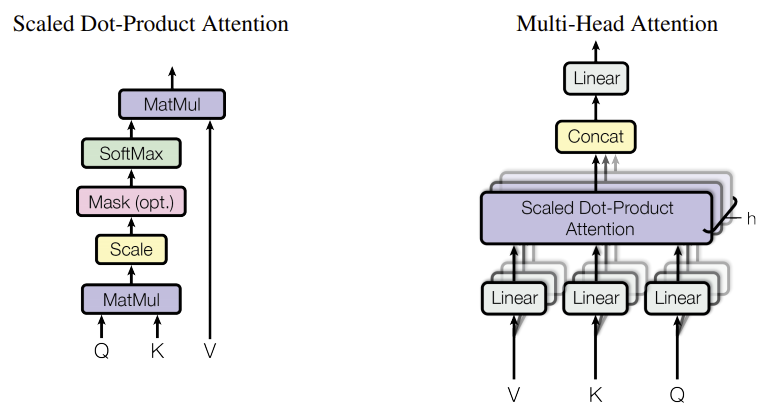
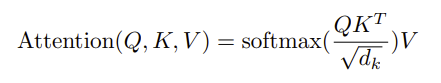

### Scaled-dot-product Attention

In [ ]:
'''
1. Q, K, V : (N, T, D), where 
- N is batch size, 
- T is sequence length and 
- D is the number of features 

Q @ K.T : (N,T,D) @ (N, D, T)  (transpose axis 1 and axis 2) 
       -> (N, T, T)
root_dk : Q.size(-1)**0.5
'''


def scaled_dot_product_attention(query:torch.Tensor, key:torch.Tensor, value:torch.Tensor)->torch.Tensor:  # value -> value
    # temp : Q @ K.T   -> (N.T.D) @ (N,D,T)  (batch size만 그대로 두고, D,T 와 T, D를 )
    # Q @ K.T -> (N, T, T)
    QKT     = query.bmm(key.transpose(1, 2))  # bmm : batch matrix multiplication (X, O, O)-> O에 해당되는 dim에 대해서만 matmul 진행
    root_dk = query.size(-1)**0.5            # squared root of D
    softmax = f.softmax( QKT / root_dk, dim= -1 ) # softmax for "T of Key", not for "T of Query", so dim = -1 is right
                                                  # dim = -2 로 맞추면 Key 에 대한 쿼리 결과(세로축)으로 1을 합산하는 꼴임
    return softmax.bmm(value) # (N,T,T)@(N,T,D) -> (N, T, D)


### Attention Heads

In [ ]:
class AttentionHead(nn.Module): # X = (N, D)  / Wq, Wk, Wv : (D, Q) or (D, K) / 일반적으로 K, Q는 같은 dimension 사용
    def __init__(self, input_dim:int, query_dim:int, key_dim:int):
        super().__init__()
        
        self.q_linear = nn.Linear(input_dim, query_dim) # generate Q 
        self.k_linear = nn.Linear(input_dim, key_dim) # generate K
        self.v_linaer = nn.Linear(input_dim, key_dim) # generate V

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor) -> torch.Tensor:
        # 인풋으로 들어온 query, key, value 텐서에 대해 linear forward를 진행하고
        # 그 과정을 통해 만들어진 Q, K, V를 그대로 scaled_dot_product_attention 에 forward 시킴        
        return scaled_dot_product_attention(
            self.q_linear(query), # query @ q_linear : (Xq : N, D) @ (Wq : D, Q) -> (N, Q)
            self.k_linear(key),   # key   @ k_linear : (Xk : N, D) @ (Wk : D, K) -> (N, K)
            self.v_linaer(value)) # value @ v_linear : (Xv : N, D) @ (Wv : D, K) -> (N, K)
    
    
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, input_dim: int, query_dim: int, key_dim: int):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(input_dim, query_dim, key_dim) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * key_dim, input_dim)  
        # num_heads 만큼 horizontally concat 되므로, 
        # multiheadAttention의 forward 결과 나오는 concated V의 dimension 은 numm_heads배 늘어난다. 
        # 즉, (N, T, K) * num_heads -> (N, T, num_heads * K)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor) -> torch.Tensor:
        return self.linear(
            torch.cat([ head(query, key, value) for head in self.heads], dim=-1)
        )

### Layers

In [ ]:
class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: torch.Tensor) -> torch.Tensor:
        # Assume that the "query" tensor is given first, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return self.norm(tensors[0] + self.dropout(self.sublayer(*tensors)))

    
def feed_forward(dim_input: int = 512, dim_feedforward: int = 2048) -> nn.Module:
    return nn.Sequential(
        nn.Linear(dim_input, dim_feedforward),
        nn.ReLU(),
        nn.Linear(dim_feedforward, dim_input),
)

def position_encoding(seq_len: int, dim_model: int, device: torch.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) -> torch.Tensor:
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / (1e4 ** (dim // dim_model))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

### Encoder

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, num_heads, dim_model, dim_feedforward, dropout):
        super().__init__()
        dim_q = max(dim_model // num_heads, 1)
        dim_k = dim_q
        
        self.attention = MultiHeadAttention(
                num_heads = num_heads,
                input_dim = dim_model,
                query_dim = dim_q, 
                key_dim   = dim_k
        )
        
        self.residual_AT = Residual(
            sublayer  = self.attention,
            dimension = dim_model,
            dropout   = dropout
        )
            
        self.feed_forward = feed_forward(
            dim_input       = dim_model,
            dim_feedforward = dim_feedforward
        )
            
        self.residual_FF = Residual(
            sublayer = self.feed_forward,
            dimension = dim_model,
            dropout   = dropout,
        )

    ''' source shape : (N, T, D)'''
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.residual_AT(x, x, x)
        return self.residual_FF(x)


class TransformerEncoder(nn.Module):
    def __init__(self, 
                 num_layers, 
                 num_heads, 
                 dim_model, 
                 dim_feedforward, 
                 dropout):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(
                    num_heads = num_heads, 
                    dim_model = dim_model, 
                    dim_feedforward = dim_feedforward, 
                    dropout = dropout
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # shape
        if(x.ndim==2):
            x = x.reshape(1, x.size(0), x.size(1))
        N, T, D = x.shape
        
        # positional encoding
        x += position_encoding(T, D)
        for layer in self.layers:
            x = layer(x)

        return x

### Decoder

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        dim_model,
        num_heads,
        dim_feedforward,
        dropout
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention_1 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.attention_2 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, ygt: torch.Tensor, encoder_out: torch.Tensor) -> torch.Tensor:
        ygt = self.attention_1(ygt, ygt, ygt)
        ygt = self.attention_2(ygt, encoder_out, encoder_out)
        return self.feed_forward(ygt)


class TransformerDecoder(nn.Module):
    def __init__(self,
                 num_layers,
                 num_heads,
                 dim_model,
                 dim_feedforward,
                 dropout
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )
        self.linear = nn.Linear(dim_model, dim_model)

    def forward(self, ygt: torch.Tensor, encoder_out: torch.Tensor) -> torch.Tensor:
        seq_len, dimension = ygt.size(1), ygt.size(2)
        ygt += position_encoding(seq_len, dimension)
        for layer in self.layers:
            ygt = layer(ygt, encoder_out)

        return torch.softmax(self.linear(ygt), dim=-1)

### Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers,
        num_decoder_layers,
        dim_model,
        num_heads,
        dim_feedforward,
        dropout,
        activation
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        return self.decoder(tgt, self.encoder(src))

### experiment

In [ ]:
all_input_list  = sorted(glob.glob("train_input/*.csv"))
all_target_list = sorted(glob.glob("train_target/*.csv"))
# for training
train_input_list = all_input_list[:50]
train_target_list = all_target_list[:50]
# for validation
test_input_list = all_input_list[50:]
test_target_list = all_target_list[50:]

X_train = []; Y_train = []
X_val  = []; Y_val  = []

# call function
preprocessing1(train_input_list, train_target_list, X_train, Y_train)
preprocessing1(test_input_list, test_target_list, X_val, Y_val)

# stack X, Y data
X_train = torch.vstack(X_train)
Y_train = torch.vstack(Y_train)
X_val  = torch.vstack(X_val)
Y_val  = torch.vstack(Y_val)

winter = pd.read_csv(train_input_list[28])
summer = pd.read_csv(train_input_list[19])
winter.columns

In [ ]:
class origin(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(origin, self).__init__()
        
        self.attention = TransformerEncoder(
            num_layers = 6,
            num_heads  = 6,
            dim_model  = input_dim,
            dim_feedforward = 512,
            dropout = 0.1
        )
                
        self.linear = nn.Linear(
            in_features  = hidden_dim,
            out_features = output_dim
        )
        
        self.layers = [
            self.attention,
            self.linear
        ]

    def forward(self, x):
        x = self.attention(x)
        
        # hiddens, last hidden state
        x = x[:, -1, :]
        
        # final output
        x = self.linear(x)
        return x
    
    
'''parameters'''
lr = 0.007
n_epochs = 30
batch_size = 64
max_norm = 3

N = batch_size
T = X_train.shape[1]
I = X_train.shape[2]
H = 256
O = Y_train.shape[1]  

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"current device : {device}")
print(f"lr             : {lr}")
print(f"n_epochs       : {n_epochs}")
print(f"batch_size(N)  : {batch_size}")
print(f"max_norm       : {max_norm}")

print()

print(f"T  : {T}")
print(f"I  : {I}")
print(f"H  : {H}")
print(f"O  : {O}")


### define model

In [ ]:
''' model setting '''
model = origin(I, H, O)
criterion = RMSELoss()
optimizer = optim.Adam(
    params=model.parameters(), 
    lr = 0.005,
    eps = 1e-06
)
scheduler = None
clip      = True

# print("-----    model    -----\n", model)
print("\n----- optimizer -----\n", optimizer)
print("\n----- scheduler -----\n", scheduler)

In [ ]:
best_model = train(
    model, 
    device, 
    criterion, 
    optimizer, 
    scheduler, 
    clip, 
    X_train, 
    Y_train, 
    X_val, 
    Y_val, 
    lr, 
    n_epochs, 
    batch_size,
    max_norm
)
